# Classifiez automatiquement des biens de consommation

Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.


Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, lead data scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

## Les données
Linda vous a fourni un premier jeu de données d’articles avec le lien pour télécharger la photo et une description associée.

## Votre mission
Votre mission est de **réaliser une première étude de faisabilité d'un moteur de classification** d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Vous **analyserez le jeu de données** en **réalisant un prétraitement** des images et des descriptions des produits, une **réduction de dimension**, puis un **clustering**. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

__Contraintes__
Linda vous a communiqué la contrainte suivante : afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.

Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

## Livrables attendus
Un **notebook** (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques au besoin).
Un support de **présentation** qui présente la démarche et les résultats du clustering.

# Analyse exploratoire des données textuelles

**[I Préparation du jeu de données](#I-Préparation-du-jeu-de-données)**
* [I.1 Chargement du jeu de données](#I.1-Chargement-du-jeu-de-données)
* [I.2 Création des catégories](#I.2-Création-des-catégories)

**[II Création du corpus](#II-Création-du-corpus)**

**[III Nettoyage et normalisation du corpus](#III-Nettoyage-et-normalisation-du-corpus)**
* [III.1 Tokenization](#III.1-Tokenization)
* [III.2 Stopwords](#III.2-Stopwords)
* [III.3 Lemmatization](#III.3-Lemmatization)
* [III.4 Résumé - fonctions de prétraitement](#III.4-Résumé---fonctions-de-prétraitement)

In [92]:
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import itertools
import time
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np 
from numpy.random import default_rng
import re
import p6

from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect
from langdetect import detect_langs

from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

import sys

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import cluster
from sklearn.model_selection import ParameterGrid

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
yb.reset_orig()

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import hdbscan

import warnings
warnings.filterwarnings('ignore')

NameError: name 'yb' is not defined

# Scripts

In [94]:
def prepare_text(sample, **kwargs):
    # création d'un motif regex à partir de quelques phrases récurrentes et non-informatives. 
    sentences_to_remove = ['rs.', 
                           'flipkart.com',
                           'free shipping',
                           'cash on delivery', 
                           'only genuine products', 
                           '30 day replacement guarantee',
                           '\n',
                           '\r',
                           '\t',
                           r'\bcm\b',
                           r'\bbuy\b',
                           r'\bl\b'
                          ]

    sent_rm = kwargs.pop('sentences_to_remove', sentences_to_remove)
    pattern = "|".join(sentences_to_remove)
    cleaned_text = re.sub(pattern, ' ', sample)
    pattern_2 = re.compile(r"\s{2,}")
    cleaned_text = re.sub(pattern_2, ' ', cleaned_text)
    return cleaned_text

def get_lemma(tokens, lemmatizer, stop_words):
    lemmatized = []
    for item in tokens:
        if item not in stop_words:
            lemmatized.append(lemmatizer.lemmatize(item))
    return lemmatized


def tokenize(sample, **kwargs):
    tokenizer = kwargs.pop('tokenizer', None)
    if tokenizer:
        tokens = tokenizer.tokenize(sample)
        lemma = kwargs.pop('lemmatizer', None)
        stop_w = kwargs.pop('stop_words', None)
        if lemma:
            if stop_w:
                lemmas = get_lemma(tokens, lemmatizer, stop_w)
            else:
                lemmas = get_lemma(tokens, lemmatizer)
        else:
            lemmas = tokens
        
        return lemmas
    else:
        print("Missing tokenizer") 
        

def process_text(sample):
    # motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux 
    # comme \n, \t \r etc., ainsi que les chiffres.
    pattern = re.compile(r'[a-zA-Z]+')
    cleaned = prepare_text(sample)
    tokens = tokenize(cleaned, tokenizer=tokenizer,lemmatizer=lemmatizer,stop_words=SW)

    return ' '.join(tokens)


def word_freq(corpus):
    
    # construction du dictionnaire des fréquences
    freq_dist = Counter()
    for text in corpus:
        for token in text.split(' '):
            freq_dist[token] += 1
    
    return freq_dist
    
    
# Fonction de filtrage des mots (les plus rares et les plus fréquents)
def filter_tokens(corpus, freq_dist, min_tf, max_tf):
    
        # On retire les tokens tels que word_freq[token] < min_tf ou > max_tf
        new_corpus = [' '.join([token for token in text.split(' ') 
                                if (freq_dist[token] > min_tf) and (freq_dist[token] < max_tf)
                               ])
                      for text in corpus]
        
        return new_corpus
            

def make_docterm_matrix(corpus, idf_transform=True, **kwargs):
    
    freq_dist = word_freq(corpus)
    
    max_tf = kwargs.pop('max_tf', None)
    if max_tf is None:
        max_tf = max(freq_dist.values())
    
    min_tf = kwargs.pop('min_tf', 1)
    corpus = filter_tokens(corpus, freq_dist, min_tf, max_tf)
    
    max_df = kwargs.pop('max_df', 1.0)
    min_df = kwargs.pop('min_df', 1)
    n_gram = kwargs.pop('ngram_range', (1, 1))
    
    tfidfargs = {'max_df':max_df, 'min_df':min_df, 'ngram_range':n_gram}
    
    tfidf = TfidfVectorizer(**tfidfargs)
    values = tfidf.fit_transform(corpus)
    
    return tfidf, values.todense()



def model_evaluation(corpus, idf_transform=False, ari=False, **kwargs):
    
    # création de la matrice 'bag_of_words'
    _, docterm = make_docterm_matrix(corpus,
                                  **kwargs
                                  )
    
    # Latent Dirichlet Allocation
    n_topics = 7
    doc_topic_prior = kwargs.pop('doc_topic_prior', None)
    topic_word_prior = kwargs.pop("topic_word_prior", None)
    
    lda = decomposition.LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online',
        doc_topic_prior=doc_topic_prior,
        topic_word_prior=topic_word_prior
    )
    
    # Fit
    lda.fit(docterm)
    
    if ari:
        # Evaluation
        # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
        X_topics = lda.transform(docterm)
        topics = np.argmax(X_topics, axis=1)
    
        return [metrics.adjusted_rand_score(labels_0, topics)]
    
    else:
        return [lda.score(docterm)]

    
def custom_gridsearch(tokenized_corpus, grid, method='model_eval', ari=True, verbose=1):
    
    results = []
    i = 0
    tinit = time.time()
    grid_length = np.prod([len(v) for v in grid.values()])

    for g in ParameterGrid(grid):
        
        t0 = time.time()
        i += 1
        
        if verbose > 0:
            print("Evaluation du modèle...{}/{}".format(i, grid_length))
            for k, v in g.items():
                print("{} = {}".format(k, v))
            print()
        
        kwargs = g
        
        if method=='model_eval':
            score = model_evaluation(tokenized_corpus,
                                     ari=ari,
                                     **kwargs)
            score_name = ["score"]
            
        elif method=='tsne':
            score = make_lsa_tsne(**kwargs)
            score_name = ["silhouette_score", "davies_bouldin_score"]
                  
        results.append([*g.values(),
                        *score])
         
        if verbose > 1:
            
            step_duration = time.time() - t0
            global_duration = time.time() - tinit
            avg_per_step = (global_duration + step_duration)/(i + 1)
        
            nb_h = avg_per_step*(grid_length - i) // 3600
            nb_min = (avg_per_step*(grid_length - i) % 3600) // 60
            nb_sec = int((avg_per_step*(grid_length - i) % 3600) % 60)
            print("temps restant estimé: {} h {} min {} s".format(nb_h, nb_min, nb_sec))
            print('-'*40)
            print()
    
    
    cols = list(g.keys())
    for s in score_name:
        cols.append(s)

    results = pd.DataFrame(data=results, columns=cols)

    if method=='model_eval':
        best_score = results["score"].max()
        index = results[results["score"]==best_score].index[0]
        best_params = results[results["score"]==best_score].transpose().rename(columns={index:"Paramètres"})
        print("Meilleur score: {:.3f}".format(best_score))
        print("Hyperparamètres utilisés pour obtenir le meilleur score: ")
        print(best_params)
        
    return results

def make_lsa_tsne(**g):
        
        ngram_range = g.pop('ngram_range', (1,1))
        kwargs1 = {'ngram_range':ngram_range}
        
        n_components = g.pop('n_components', 2)
        perplexity = g.pop('perplexity', 30)
        n_iterations = g.pop('iterations', 1000)
        kwargs2 = {'n_components':n_components}
        kwargs3 = {'perplexity':perplexity,
                   'n_iter':n_iterations}
        
        _, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True, **kwargs1)
        lsa_tsne = pipeline.make_pipeline(decomposition.TruncatedSVD(**kwargs2),
                                          preprocessing.Normalizer(copy=False),
                                          manifold.TSNE(**kwargs3))
    
        print("Création de la représentation 2D par t-SNE... ")
        print("perplexity = {}, n_iterations = {}, ngram_range = {}".format(kwargs3["perplexity"], 
                                                                            kwargs3["n_iter"],
                                                                            kwargs1["ngram_range"]))
        array_tsne = lsa_tsne.fit_transform(docterm)
    
        df_tsne = pd.DataFrame(data=array_tsne, columns=["t-SNE 0", "t-SNE 1"])
        silh_score = metrics.silhouette_score(df_tsne, data.product_category_1)
        db_score = metrics.davies_bouldin_score(df_tsne, data.product_category_1)
        
        score = [silh_score, db_score]
        return score
    
    
def plot_silhouette_analysis(X, data, label_col):
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, data[label_col])
    
    y_lower = 10
    for i in range(data[label_col].nunique()):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[data[label_col] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = mpl.cm.nipy_spectral(float(i) / data[label_col].nunique())
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = mpl.cm.nipy_spectral(data[label_col].astype(float) / data[label_col].nunique())
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], 
        marker=".", 
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k"
    )
    
    
    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    centroids = []
    for t in data[label_col].unique():
        cluster_indices = np.where(data[label_col]==t)
        centroids.append(X.iloc[cluster_indices].sum(axis=0) / len(cluster_indices[0]))
    
    centroids = np.asarray(centroids)
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centroids):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.tight_layout()
    plt.show()
    
    
def plot_gs_results(results, score, axis_scale="log", plot_param=["alpha"], savefig=False, figname='untitled'):
    """Plots GridSearchCV results.
    
    Draw a plot (one plot per hyperparameter) of mean_train and mean_test scores/errors 
    for each hyperparameter being optimised.
    
    Parameters
    ----------
    cv_results : pandas.DataFrame
        GridSearchCV cross-validation results
    
    score : str or tuple
        Metric(s) used to evaluate the predictions
        
    axis_scale : str, default="log"
        Type of scale to use to draw the plot. Basically 'linear' or 'log' depending on the hyperparameter
    
    plot_param : list, default=["alpha"]
        Hyperparameter against which to plot cross-validated results
        
    savefig : bool, default=False
        Whether or not to save the plot to a .png file.
        
    figname : str, default='untitled'
        Name to give the file if savefig is True.
        
        
    """
    fig = plt.figure(figsize=(5*(len(plot_param)//2 + 1), 4*2))
    
    # Affiche les scores obtenus sur les jeux d'entrainement et de test
    for i, pp in enumerate(plot_param):
        d = results.set_index("{}".format(pp))
        cols = []
        for s in score: 
                cols.append("{}".format(s))
                
        if None in d.index:
            d.rename(index={None: 'None'})
        
        ax = fig.add_subplot(2, len(plot_param)//2 + 1, i+1)
        sns.lineplot(data=d[cols], ci='sd', ax=ax)
        ax.set_xscale(axis_scale)
        ax.set_xlabel(pp, size=12)
        ax.legend(loc='best', frameon=False, fontsize='small')
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        
    if savefig:
        plt.savefig(f'./{figname}', dpi=300)
        
    plt.tight_layout()


def visualize_tsne(data, X_tsne, label_col, title="K-Means clusterization"):
    
    X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])
    df = pd.concat([X_tsne, data[[label_col, "product_category_0"]]], axis=1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12, 5))

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue=label_col,palette='tab20', legend=False, ax=ax1)
    #ax1.legend(np.arange(len(np.unique(df.hdbs_label)))-1)
    ax1.set_title(title)

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10', ax=ax2)
    ax2.set_title("Original segmentation (level 0)")
    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

# I Préparation du jeu de données

## I.1 Chargement du jeu de données

Commençons par charger le jeu de données

In [5]:
try:
    data = p6.load_data()
except:
    rootpath = "./data/Flipkart/"
    data = pd.read_csv(rootpath+"flipkart_com-ecommerce_sample_1050.csv")
    data.head()

Les données qui vont nous intéresser ici appartiennent sont:
- les descriptions des produits
- les noms des produits

## I.2 Création des catégories

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Nombre de catégories différentes par niveau:
--------------------------------------------------
0      7
1     62
2    241
3    349
4    297
5    117
6     57
dtype: int64


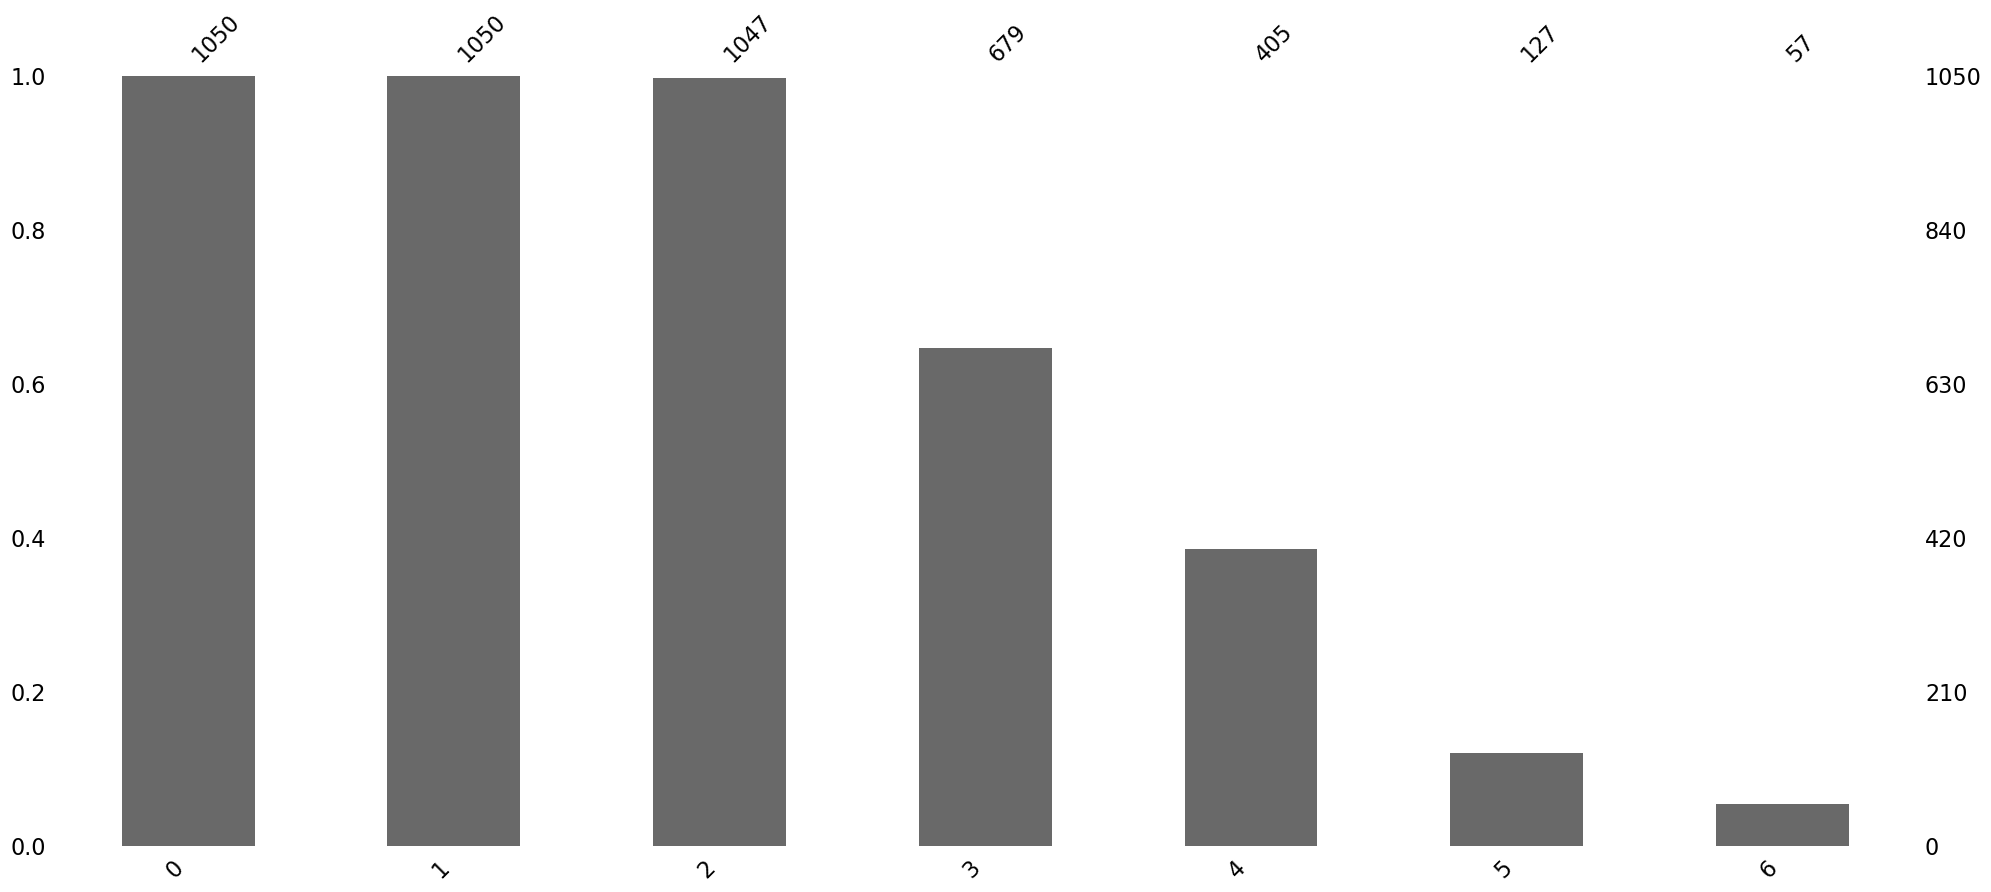

In [8]:
categories = p6.category_trees(data)
msno.bar(categories)
print("Nombre de catégories différentes par niveau:")
print("-"*50)
print(categories.nunique())

In [9]:
categories

,0,1,2,3,4,5,6
0,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None
...,...,...,...,...,...,...,...
1045,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None
1046,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None
1047,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None
1048,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None


In [10]:
data["product_category_0"] = p6.extract_categories_from_tree(data)
data["product_category_1"] = p6.extract_categories_from_tree(data, level=1)
data = data[["product_name", "description", "product_category_0", "product_category_1"]]
data.head()

,product_name,description,product_category_0,product_category_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen


**Combien de produits par catégorie? Les catégories sont-elles équilibrées?**

In [122]:
data.groupby('product_category_0').size()

product_category_0
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
dtype: int64

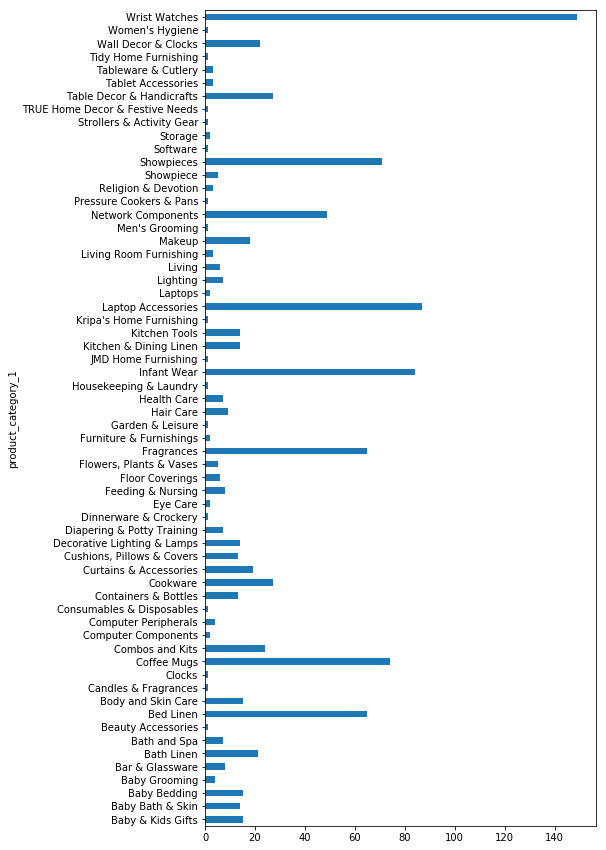

In [129]:
plt.figure(figsize=(7, 15))
data.groupby('product_category_1').size().plot(kind='barh')

Au deuxième niveau de catégorisation, les catégories ne sont plus du tout équilibrées. Ceci suggère que les produits ont été choisis (aléatoirement?) de manière à ce que chaque catégorie de niveau 0 soit représentée également.

In [1174]:
for cat in data.product_category_0.unique():
    print(cat)
    print(data.loc[data["product_category_0"]==cat, "product_category_1"].value_counts())
    print('-'*20)
    print()

Home Furnishing
Bed Linen                     65
Bath Linen                    21
Curtains & Accessories        19
Kitchen & Dining Linen        14
Cushions, Pillows & Covers    13
Living                         6
Floor Coverings                6
Living Room Furnishing         3
JMD Home Furnishing            1
Kripa's Home Furnishing        1
Tidy Home Furnishing           1
Name: product_category_1, dtype: int64
--------------------

Baby Care
Infant Wear                   84
Baby Bedding                  15
Baby & Kids Gifts             15
Baby Bath & Skin              14
Feeding & Nursing              8
Diapering & Potty Training     7
Baby Grooming                  4
Furniture & Furnishings        2
Strollers & Activity Gear      1
Name: product_category_1, dtype: int64
--------------------

Watches
Wrist Watches    149
Clocks             1
Name: product_category_1, dtype: int64
--------------------

Home Decor & Festive Needs
Showpieces                         71
Table Decor & Ha

# II Création du corpus

## II.1 Affichage d'exemples choisis aléatoirement

On commence par écrire une petite routine qui va nous permettre d'afficher une description de produit choisie au hasard dans la liste des descriptions (data["description"])

In [10]:
def get_sample(n=1):
    """Returns a raw sample form the corpus"""
    sample = data["description"].sample(n).values
    return sample

Affichons 10 exemples tirés au hasard:

In [12]:
print(get_sample(10))

["Rega IT Hp Pavilion DV2535TX DV2536TX 12 Cell 12 Cell Laptop Battery\r\n                         Price: Rs. 2,499\r\n\t\t\t\t\r\n\t\t\tRega IT Replacement 12 Cell (Extended) Laptop Battery for Hp Pavilion DV2535TX DV2536TX Laptop Made from highest quality parts each Rega IT replacement Battery confirms to specifications similar and guaranteed to meet or exceed your laptop's minimum requirements. Each Battery also passes necessary authentication certifications like CE, ROHS etc. Before leaving the factory, so you can be rest assured for its quality, durability and performance. Please make sure that you are selecting the correct Battery as per you old Battery specification. Please compare your old Battery Power Rating i.e. Volts (V), Capacity (mAh) & Cells.\r\nRega IT Replacement 12 Cell (Extended) Laptop Battery for Hp Pavilion DV2535TX DV2536TX Laptop Made from highest quality parts each Rega IT replacement Battery confirms to specifications similar and guaranteed to meet or exceed y

On remarque que le texte est en anglais sur ces exemples, qu'il y a du texte ainsi que des nombres et ce qui semble être des numéros de séries ainsi que des abréviations. Il y a également des url ainsi que des caractères spéciaux. On remarque également d'ors-et-déjà la présence de phrases telles que "cash on delivery", "free shipping" etc. qui semblent revenir souvent mais ne présentent aucun intérêt du point de vue de la catégorisation des produits. On pourra songer à les éliminer du dataset dès le prétraitement, même si elles seront sans doute filtrées lors du calcul de la matrice tf-idf. Quoi qu'il en soit il faudra tenir compte de tout ces éléments pour réaliser une tokenization efficace du corpus.

# III Nettoyage et normalisation du corpus
## III.0 Vérification du langage utilisé

On commence par nettoyer le corpus: on retire les caractères spéciaux

In [13]:
def clean_sample(sample):
    
    cleaned_sample = re.sub('\n|\r|\t', ' ', sample)
    cleaned_sample = re.sub('\s{2,}', ' ', cleaned_sample)
    
    return cleaned_sample

In [14]:
detected = list()
for sample in tqdm(data.description):
    cleaned_sample = clean_sample(sample)
    detected.append([(dl.lang, dl.prob) for dl in detect_langs(cleaned_sample)])

100%|██████████| 1050/1050 [00:14<00:00, 70.85it/s]


In [39]:
raw_detected = pd.DataFrame(detected)
first_lang = pd.DataFrame.from_records(raw_detected[0].tolist(), columns=["first_lang", "first_prob"])
d = pd.concat([first_lang, raw_detected[1]], axis=1)
d[1] = d[1].apply(lambda x: (x, x) if x is None else x)

second_lang = pd.DataFrame.from_records(d[1].tolist(), columns=["second_lang", "second_prob"])
detected_languages = pd.concat([d.drop(columns=1), second_lang], axis=1)
detected_languages.head()

,first_lang,first_prob,second_lang,second_prob
0,en,0.999996,None,NaN
1,en,0.999996,None,NaN
2,en,0.999999,None,NaN
3,en,0.999995,None,NaN
4,en,0.999996,None,NaN


In [40]:
# ISO-codes for languages
wiki_page = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')
iso_codes = wiki_page[1][["ISO language name", "639-1"]]
iso_codes.head()

,ISO language name,639-1
0,Abkhazian,ab
1,Afar,aa
2,Afrikaans,af
3,Akan,ak
4,Albanian,sq


In [41]:
# Langages utilisés dans le dataset:
detected_languages["first_lang"] = (detected_languages.first_lang
 .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"].values[0])
)

detected_languages["second_lang"] = (detected_languages["second_lang"]
                                    .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"]
                                           .values[0] 
                                           if x else x)
                                    )

In [55]:
print("Langue(s) principale(s) détectée(s): " + ", ".join([fl for fl in detected_languages.first_lang.unique()]))
print("Langue(s) secondaire(s) détectée(s): " + ", ".join([fl for fl in detected_languages.second_lang.unique() if fl]))

Langue(s) principale(s) détectée(s): English
Langue(s) secondaire(s) détectée(s): Italian, Indonesian, German


In [56]:
detected_languages[detected_languages.second_lang.notna()]

,first_lang,first_prob,second_lang,second_prob
197,English,0.714283,Italian,0.285716
267,English,0.428573,Indonesian,0.285713
1013,English,0.857139,German,0.142858


In [57]:
sample = data.iloc[197]["description"]
sample

'Sam Rolling Pizza Cutter (Steel Pack of 1)\r\n                         Price: Rs. 45\r\n\t\t\t\t\r\n\t\t\tDurable Good Quality Pizza Cutter\r\nDurable Good Quality Pizza Cutter'

In [58]:
clean_sample(sample)

'Sam Rolling Pizza Cutter (Steel Pack of 1) Price: Rs. 45 Durable Good Quality Pizza Cutter Durable Good Quality Pizza Cutter'

In [18]:
sample = data.iloc[267]["description"]
sample

'Sahara Q Shop Kadhai 1.5 L (Stainless Steel)\r\n                         Price: Rs. 650\r\n\t\t\t\t\r\n\t\t\tPremium Non Stick Kadhai 1.5.Ltr\r\nPremium Non Stick Kadhai 1.5.Ltr'

In [19]:
clean_sample(sample)

'Sahara Q Shop Kadhai 1.5 L (Stainless Steel) Price: Rs. 650 Premium Non Stick Kadhai 1.5.Ltr Premium Non Stick Kadhai 1.5.Ltr'

In [20]:
sample = data.iloc[1013]["description"]
sample

'Key Features of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men Fragrance Classification: Deodorant Spray,LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men (210 ml) Price: Rs. 447 Lawman Deodorant Combo For Men,Specifications of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray  -  For Men (210 ml) Fragrance Traits Fragrance Classification Deodorant Spray Quantity 210 ml Ideal For Men In the Box 3 Deodorant'

In [21]:
clean_sample(sample)

'Key Features of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men Fragrance Classification: Deodorant Spray,LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Price: Rs. 447 Lawman Deodorant Combo For Men,Specifications of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Fragrance Traits Fragrance Classification Deodorant Spray Quantity 210 ml Ideal For Men In the Box 3 Deodorant'

Le détecteur de langue fonctionne bien la plupart du temps, c'est-à-dire qu'il reconnaît l'anglais comme la langue des descriptions. Dans quelques cas, le détecteur "croit" reconnaître d'autres langues, mais il s'agit manifestement de "faux" - d'ailleurs les probabilités associées sont plutôt basses comparé au 99%+ qu'on obtient généralement lorsqu'il n'y a pas d'ambiguité. L'ambiguité provient certainement de la présence de mots étrangers écrits avec l'alphabet latin (lorsque le détecteur s'attendrait à un autre alphabet, ou un autre langage utilisant l'alphabet latin), et peut-être de la présence de caractères spéciaux. Il faudrait en principe retirer ces caractères spéciaux avant de faire fonctionner le détecteur.
En conclusion: on va considérer qu'on n'a affaire qu'à de l'anglais dans ce dataset.

## III.1 Fonctions de prétraitement

In [11]:
# création du set de stopwords
SW = set()
SW.update(nltk.corpus.stopwords.words('english'))
SW.update(STOP_WORDS)

# fonctions de lemmatization et tokenization
lemmatizer = WordNetLemmatizer()

# motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux comme 
# \n, \t \r etc., ainsi que les chiffres.
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

**Démonstration de la tokenization sur un exemple**

In [12]:
s = data.description.sample(1).to_numpy()[0].lower()
print("Texte original")
print("-"*14)
s

Texte original
--------------


'buy wallmantra extra large vinyl stickers sticker for rs.1216 online. wallmantra extra large vinyl stickers sticker at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee.'

In [13]:
print("Après tokenization")
print("-"*18)
print(process_text(s))

Après tokenization
------------------
wallmantra extra large vinyl sticke sticker online wallmantra extra large vinyl sticke sticker best price


# IV Création des bag-of-words

## IV.1 Préparation du corpus (preprocessing)

### IV.1.1 tokenization, lemmatization

In [14]:
tokenized_corpus = [process_text(desc.lower()) for desc in data.description]
tokenized_corpus = np.asarray(tokenized_corpus, dtype='object')

In [258]:
tokenized_corpus[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interio curtain high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart fi thing morning welcome bright sun ray want wish good morning world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filte light room right sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model abstract polyester door curtain set model id duster color multicolor dimension length box number content sale package pack sale package curtain body des

### IV.1.2 Analyse exploratoire: mots les plus fréquents par catégorie de produits

In [12]:
most_frequent = dict()
for cat in data.product_category_0:
    cat_indices = data[data.product_category_0==cat].index.tolist()
    word_count = Counter()
    for text in tokenized_corpus[cat_indices]:
        for token in text.split(' '):
            word_count[token] += 1
    most_frequent[cat] = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [13]:
print("mots les plus fréquents par catégorie de produit")
print("-"*50)
print()
for cat in data.product_category_0.unique():
    print(cat)
    print('-'*15)
    print(', '.join([m for m in list(zip(*most_frequent[cat]))[0][:20]]))
    print()

mots les plus fréquents par catégorie de produit
--------------------------------------------------

Home Furnishing
---------------
cotton, pack, cover, design, towel, cushion, inch, package, sale, polyester, color, material, single, price, feature, multicolor, curtain, width, blanket, floral

Baby Care
---------------
baby, girl, cotton, detail, fabric, boy, dress, specification, ideal, general, package, feature, sleeve, type, sale, neck, wash, number, pattern, content

Watches
---------------
watch, analog, men, online, india, great, discount, woman, dial, strap, boy, resistant, water, round, sonata, maximum, digital, girl, case, black

Home Decor & Festive Needs
---------------
showpiece, price, best, inch, wall, online, home, color, feature, brass, number, product, gift, art, material, box, dimension, beautiful, package, x

Kitchen & Dining
---------------
mug, ceramic, coffee, perfect, price, material, design, gift, ml, feature, specification, safe, product, pack, quality, loved,

Certains mots apparaissent dans plusieurs catégories de produit. Cela peut potentiellement nuire à la segmentation, il faudra voir comment les filtrer (ou les utiliser).
On peut regarder quels sont les mots parmi les 10 mots les plus utilisés qui reviennent dans plusieurs catégories

In [10]:
setlist = [set(list(zip(*most_frequent[cat]))[0][:10]) for cat in data.product_category_0]
set.intersection(*setlist)

set()

Aucun mot parmi les 10 plus fréquents de chaque catégorie n'apparaît dans toutes les catégories. A l'inverse, on peut regarder quels sont les mots qui reviennent dans chaque paire de catégorie.

In [14]:
intersect = []
for comb_cat in itertools.combinations(data.product_category_0.unique(), 2):
    setlist = [set(list(zip(*most_frequent[cat]))[0][:20]) for cat in comb_cat]
    intersect.append(set.intersection(*setlist))
multi_category_words = set(itertools.chain.from_iterable(intersect))
multi_category_words

{'best',
 'box',
 'boy',
 'color',
 'cotton',
 'design',
 'feature',
 'gift',
 'girl',
 'ideal',
 'inch',
 'material',
 'ml',
 'number',
 'online',
 'pack',
 'package',
 'price',
 'product',
 'quality',
 'sale',
 'skin',
 'specification',
 'type'}

Ces mots sont donc des mots qui sont fréquemment utilisés dans au moins deux catégories. On peut essayer de les supprimer, car ils contribuent à rendre les distinctions entre catégories moins nettes.

## IV.2 Processing pipeline
### IV.2.1 Représentation "bag-of-words" - _Document-term matrix_

In [15]:
tfidf, docterm = make_docterm_matrix(tokenized_corpus,
                              idf_transform=True,
                              min_tf=10,
                              max_tf=400,
                              min_df=2,
                              max_df=0.5,
                              ngram_range=(1, 2)      
                                    )
pd.DataFrame(docterm, columns=tfidf.get_feature_names())

,absorbent,abstract,abstract art,abstract ceramic,abstract cushion,abstract design,abstract double,abstract eyelet,abstract floral,abstract single,...,yes model,yes organic,yes pot,yes type,yes warranty,yes yes,ym,ym analog,ym online,ym watch
0,0.0,0.165343,0.0,0.0,0.0,0.0,0.0,0.204911,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.050609,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### IV.2.2 Evaluation de la "qualité" des vraies catégories

**1. Evaluation des catégories de niveau 0**

1. Combien de composantes retenir dans la SVD?

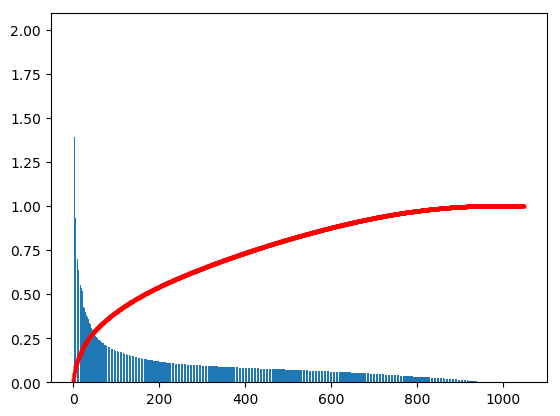

In [90]:
# création de la matrice 'bag_of_words'
_, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True, ngram_range=(1, 2))
svd = decomposition.TruncatedSVD(n_components=1050).fit(docterm)

fig, ax = plt.subplots()
svd_var_ratio = svd.explained_variance_ratio_
ax.bar(np.arange(1050), 100*svd_var_ratio)
ax.plot(np.arange(1050), svd_var_ratio.cumsum(), c='red', marker='o', markersize=2)
plt.show()

On réalise une recherche sur grille (gridsearch) pour déterminer la combinaison de paramètres (nb de composantes de la SVD, perplexité et nb d'itérations pour t-SNE) optimale.

In [91]:
grid = {"n_components": [800, 400, 200, 100], 
        "perplexity":[100, 50, 30, 10], 
        "n_iterations":[4000],
        "ngram_range":[(1, 1), (1, 2)]
       }

results = custom_gridsearch(tokenized_corpus, grid, method='tsne', verbose=2)

Evaluation du modèle...1/32
n_components = 800
n_iterations = 4000
ngram_range = (1, 1)
perplexity = 100

Création de la représentation 2D par t-SNE... 
perplexity = 100, n_iterations = 1000, ngram_range = (1, 1)
temps restant estimé: 0.0 h 26.0 min 40 s
----------------------------------------

Evaluation du modèle...2/32
n_components = 800
n_iterations = 4000
ngram_range = (1, 1)
perplexity = 50

Création de la représentation 2D par t-SNE... 
perplexity = 50, n_iterations = 1000, ngram_range = (1, 1)
temps restant estimé: 0.0 h 22.0 min 11 s
----------------------------------------

Evaluation du modèle...3/32
n_components = 800
n_iterations = 4000
ngram_range = (1, 1)
perplexity = 30

Création de la représentation 2D par t-SNE... 
perplexity = 30, n_iterations = 1000, ngram_range = (1, 1)
temps restant estimé: 0.0 h 20.0 min 35 s
----------------------------------------

Evaluation du modèle...4/32
n_components = 800
n_iterations = 4000
ngram_range = (1, 1)
perplexity = 10

Création

temps restant estimé: 0.0 h 2.0 min 46 s
----------------------------------------

Evaluation du modèle...29/32
n_components = 100
n_iterations = 4000
ngram_range = (1, 2)
perplexity = 100

Création de la représentation 2D par t-SNE... 
perplexity = 100, n_iterations = 1000, ngram_range = (1, 2)
temps restant estimé: 0.0 h 2.0 min 6 s
----------------------------------------

Evaluation du modèle...30/32
n_components = 100
n_iterations = 4000
ngram_range = (1, 2)
perplexity = 50

Création de la représentation 2D par t-SNE... 
perplexity = 50, n_iterations = 1000, ngram_range = (1, 2)
temps restant estimé: 0.0 h 1.0 min 22 s
----------------------------------------

Evaluation du modèle...31/32
n_components = 100
n_iterations = 4000
ngram_range = (1, 2)
perplexity = 30

Création de la représentation 2D par t-SNE... 
perplexity = 30, n_iterations = 1000, ngram_range = (1, 2)
temps restant estimé: 0.0 h 0.0 min 40 s
----------------------------------------

Evaluation du modèle...32/32
n_

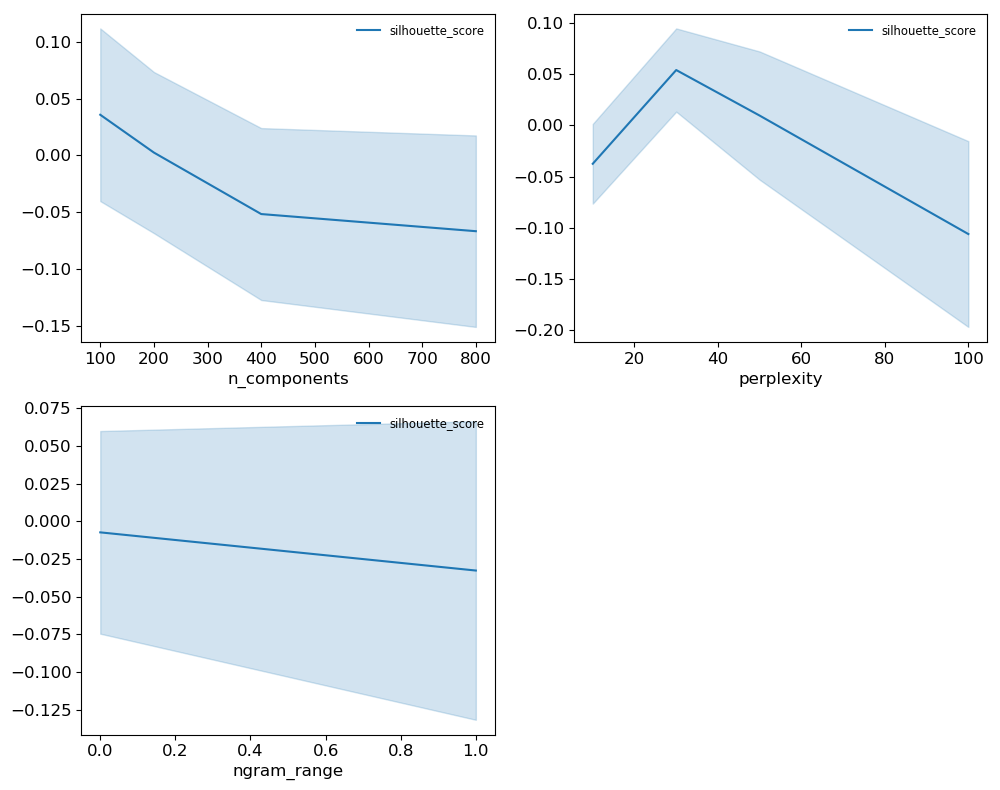

In [95]:
tsne_gs_results = pd.DataFrame(results, columns=["n_components",
                                                 "perplexity",
                                                 "n_iterations",
                                                 "ngram_range",
                                                 "silhouette_score",
                                                 "davies_bouldin_score"])

tsne_gs_results["ngram_range"] = tsne_gs_results["ngram_range"].apply(lambda x: 0 if x==(1, 1) else 1)
grid_keys = [
    "n_components",
    "perplexity",
    "ngram_range"
]

score = [
    "silhouette_score",
    #"davies_bouldin_score"
]

plot_gs_results(tsne_gs_results, score, plot_param=grid_keys, axis_scale='linear')

In [ ]:
tsne_gs_resul

On utilise les paramètres utilisés pour obtenir les meilleures valeurs ci-dessus pour ré-entraîner le pipeline et produire un plot 2D

1. Silhouette score

In [1207]:
best_silh = tsne_gs_results.silhouette_score.max()

best_params = tsne_gs_results[tsne_gs_results["silhouette_score"]==best_silh]
best_params

,n_components,perplexity,n_iterations,ngram_range,silhouette_score,davies_bouldin_score
26,100,30,4000,0,0.137894,3.558656


In [1208]:
# On laisse la réduction de dimension à charge de la SVD 
_, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True, ngram_range=(1, 1))
svd = decomposition.TruncatedSVD(n_components=best_params.n_components.to_numpy()[0])
normalizer = preprocessing.Normalizer(copy=False)
lsa = pipeline.make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(docterm)

print("Variance expliquée par les features sélectionnées: {}%"
      .format(int(svd.explained_variance_ratio_.sum()*100)))

Variance expliquée par les features sélectionnées: 49%


**2. Réduction de dimension par t-SNE**

In [1209]:
tsne = manifold.TSNE(perplexity=best_params.perplexity.to_numpy()[0], n_iter=best_params.n_iterations.to_numpy()[0], verbose=1)
X_tsne = tsne.fit_transform(X)
X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.005s...
[t-SNE] Computed neighbors for 1050 samples in 0.391s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.537605
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.187614
[t-SNE] KL divergence after 4000 iterations: 0.542730


**3. Création des visualisations t-SNE pour les catégories de niveaux 0 et 1**

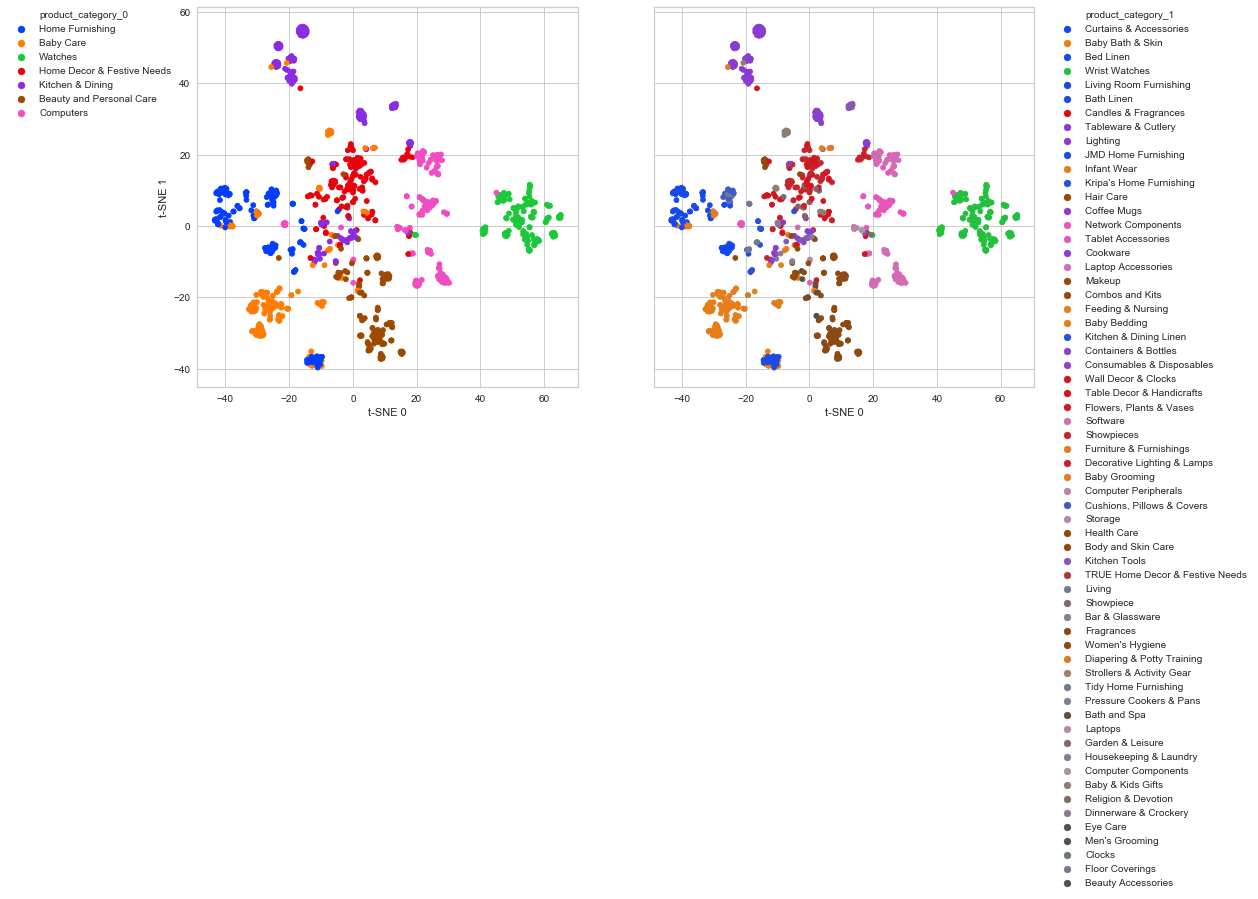

In [1235]:
df = pd.concat([X_tsne, data.product_category_0, data.product_category_1], axis=1)
colors = sns.color_palette('bright', 7)
palette = {cat:col for cat, col in zip(data.product_category_0.unique(), colors[:7])}
palette1 = {}
for cat in data.product_category_0.unique():
    level1_cat = sorted([(scat, nb_points) for scat, nb_points in zip(data.loc[data.product_category_0==cat, "product_category_1"].unique(), 
                                                    data.loc[data.product_category_0==cat, "product_category_1"].value_counts()
                                                   )
                 ], key=lambda tuple:tuple[1], reverse=True)
    #prop = np.linspace(0, 1, num=len(level1_cat))[::-1]
    for i, (scat, nb_p) in enumerate(level1_cat):
        palette1[scat] = sns.desaturate(palette[cat], max(1-1/(2*np.log(nb_p)), 0.1))
        size = nb_p

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 7))
sns.scatterplot(data=df, 
                x="t-SNE 0", 
                y="t-SNE 1", 
                hue="product_category_0", 
                palette=palette, 
                marker='.', 
                s=100, 
                lw=0,
                #alpha=0.7,
                edgecolor=None,
                ax=ax1)

# Put the legend out of the figure
ax1.legend(bbox_to_anchor=(-0.5, 1), loc=2, borderaxespad=0.)

sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", 
                hue="product_category_1",
                palette=palette1,
                #style="product_category_0",
                s=100,
                lw=0,
                #alpha=0.7,
                marker='.',
                edgecolor=None,
                #legend=False,
               ax=ax2)

# Put the legend out of the figure
#legend_labels = palette1.keys()
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

**4. Evaluation des catégories**

1. Score de silhouette

In [1214]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_avg = metrics.silhouette_score(X_tsne, data.product_category_0)
print("Le score de silhouette moyen est:", silhouette_avg)
print("Le score de Davies-Bouldin est:", )

Le score de silhouette moyen est: 0.29608673


In [1215]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_avg = metrics.silhouette_score(X_tsne, data.product_category_1)
print("Le score de silhouette moyen est:", silhouette_avg)

Le score de silhouette moyen est: 0.093770534


In [ ]:
plot_silhouette_analysis(X_tsne, data, "label_0")

2. Davies-Bouldin

In [511]:
best_dbs = davies_bouldin_scores["davies_bouldin_score"].min()
best_params = davies_bouldin_scores[davies_bouldin_scores["davies_bouldin_score"]==best_dbs]
best_params

,n_components,perplexity,n_iterations,davies_bouldin_score
64,800,10,2000,1.373706


In [483]:
print("Variance expliquée par les features sélectionnées: {}%"
      .format(int(svd.explained_variance_ratio_.sum()*100)))

Variance expliquée par les features sélectionnées: 98%


**2. Réduction de dimension par t-SNE**

In [489]:
tsne = manifold.TSNE(perplexity=best_params.perplexity.to_numpy()[0], n_iter=best_params.n_iterations.to_numpy()[0], verbose=1)
X_tsne = tsne.fit_transform(X)
X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.092s...
[t-SNE] Computed neighbors for 1050 samples in 2.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.240307
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.571068
[t-SNE] KL divergence after 2000 iterations: 0.727230


**3. Création de la visualisation t-SNE**

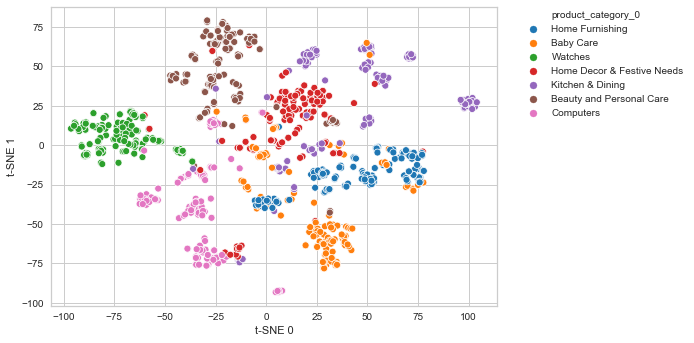

In [490]:
df = pd.concat([X_tsne, data.product_category_0], axis=1)

fig, ax = plt.subplots()
sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10')

# Put the legend out of the figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

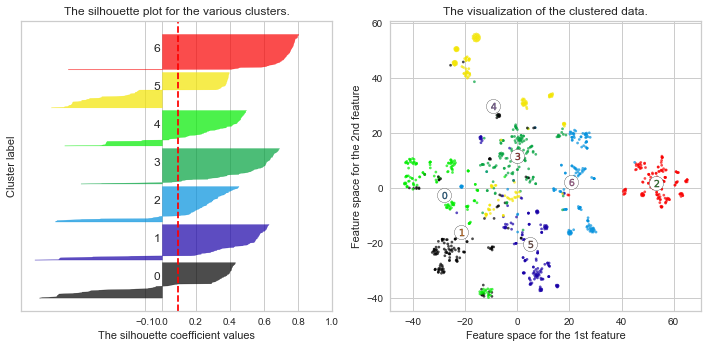

In [1244]:
plot_silhouette_analysis(X_tsne, data, "label_0")

**2. Evaluation des catégories de niveau 1**

In [527]:
results = []
params = {"n_components": [100, 400, 800], 
        "perplexity":[10, 50, 100], 
        "n_iterations":[1000, 2000, 4000]}
i = 0

for g in ParameterGrid(params):
    t0 = time.time()
    i += 1
    print("Création de la matrice document-term...{}/{}".format(i, 27))
    print("n_composantes = {}".format(g["n_components"]))

    # On laisse la réduction de dimension à charge de la SVD 
    docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True)
    svd = decomposition.TruncatedSVD(n_components=g["n_components"])
    normalizer = preprocessing.Normalizer(copy=False)
    tsne = manifold.TSNE(perplexity=g["perplexity"], n_iter=g["n_iterations"])
    lsa_tsne = pipeline.make_pipeline(svd, normalizer, tsne)
    
    print("Création de la représentation 2D par t-SNE... ")
    print("perplexity = {}, n_iterations = {}".format(g["perplexity"], g["n_iterations"]))
    array_tsne = lsa_tsne.fit_transform(docterm)
    
    #X_tsne = tsne.fit_transform(X)
    df_tsne = pd.DataFrame(data=array_tsne, columns=["t-SNE 0", "t-SNE 1"])
        
    # evaluations
    print("Evaluation des scores...")
    results.append((g["n_components"],
                    g["perplexity"],
                    g["n_iterations"],
                    metrics.silhouette_score(df_tsne, data.product_category_1),
                    metrics.davies_bouldin_score(df_tsne, data.product_category_1)))
            
    duration = time.time() - t0
    nb_min = time.gmtime(duration*(27 - i))[4]
    nb_sec = time.gmtime(duration*(27 - i))[5]
    print("temps restant estimé: {} min {} s".format(nb_min, nb_sec))
    print('-'*40)
    print()
results = pd.DataFrame(results, columns=["n_components", "perplexity", "n_iterations", "silhouette_score", "davies_bouldin_score"])

Création de la matrice document-term...1/27
n_composantes = 100
Création de la représentation 2D par t-SNE... 
perplexity = 10, n_iterations = 1000
Evaluation des scores...
temps restant estimé: 9 min 11 s
----------------------------------------

Création de la matrice document-term...2/27
n_composantes = 100
Création de la représentation 2D par t-SNE... 
perplexity = 50, n_iterations = 1000
Evaluation des scores...
temps restant estimé: 10 min 27 s
----------------------------------------

Création de la matrice document-term...3/27
n_composantes = 100
Création de la représentation 2D par t-SNE... 
perplexity = 100, n_iterations = 1000
Evaluation des scores...
temps restant estimé: 13 min 46 s
----------------------------------------

Création de la matrice document-term...4/27
n_composantes = 100
Création de la représentation 2D par t-SNE... 
perplexity = 10, n_iterations = 2000
Evaluation des scores...
temps restant estimé: 11 min 54 s
----------------------------------------

Créa

In [529]:
results.sort_values(by=["silhouette_score"], ascending=False).head()

,n_components,perplexity,n_iterations,silhouette_score,davies_bouldin_score
1,100,50,1000,0.114802,4.269099
7,100,50,4000,0.066477,4.726885
4,100,50,2000,0.063016,5.243883
5,100,100,2000,0.053807,4.203045
8,100,100,4000,0.041206,4.820422


In [530]:
results.sort_values(by=["davies_bouldin_score"], ascending=True).head()

,n_components,perplexity,n_iterations,silhouette_score,davies_bouldin_score
22,800,50,2000,-0.060953,3.643962
21,800,10,2000,-0.088104,3.803704
9,400,10,1000,-0.122627,3.987824
2,100,100,1000,0.024661,4.180933
5,100,100,2000,0.053807,4.203045


## IV.5 Apprentissage non-supervisé de catégories

### IV.5.1 Encodage des "vraies" catégories

In [82]:
# Encodage numérique des vraies catégories
le = preprocessing.LabelEncoder()
labels_0 = le.fit_transform(data.product_category_0)
data['label_0'] = labels_0

# Encodage numérique des vraies catégories
le1 = preprocessing.LabelEncoder()
labels_1 = le1.fit_transform(data.product_category_1)
data['label_1'] = labels_1

### IV.5.2 Recherche des meilleurs paramètres pour LDA

On réalise une recherche sur grille pour déterminer les paramètres optimaux d'une LDA. Les résultats de cette recherche ont été au préalable sauvegardés dans un le fichier LDA_gs_results.csv. On commence donc par importer ce fichier.

In [89]:
#grid = {"min_tf" : [1, 5, 30],
#        "max_tf" : [None, 400],
#        "min_df" : [2, 5],
#        "max_df" : [0.5],
#        "doc_topic_prior" : [1/2, None],
#        "topic_word_prior" : [1/70, None, 1/2]
#        }

#results = custom_gridsearch(tokenized_corpus, grid, method='model_eval', ari=True, verbose=1)

#results.to_csv('./LDA_gs_results.csv', index_label=False)
results = pd.read_csv('./LDA_gs_results.csv')

Evaluation du modèle...1/1
doc_topic_prior = None
max_df = 0.5
max_tf = 400
min_df = 5
min_tf = 5
topic_word_prior = 0.5

Meilleur score: 0.189
Hyperparamètres utilisés pour obtenir le meilleur score: 
                 Paramètres
doc_topic_prior        None
max_df                  0.5
max_tf                  400
min_df                    5
min_tf                    5
topic_word_prior        0.5
score              0.189478


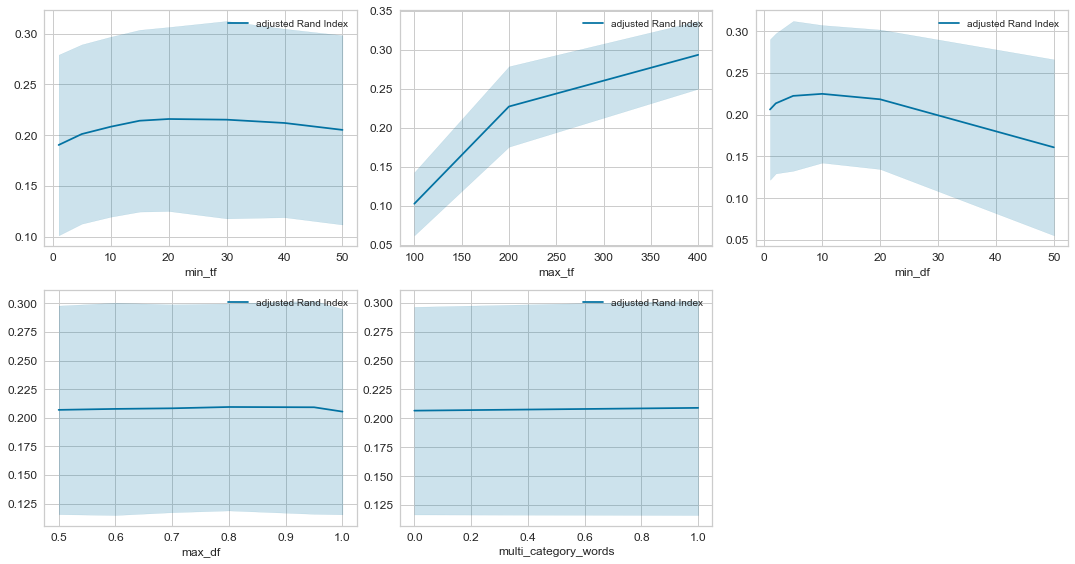

In [665]:
grid_keys = [
    "min_tf",
    "max_tf",
    "min_df", 
    "max_df",
    "multi_category_words"
]

score = ["adjusted Rand Index"]
plot_gs_results(results, score, plot_param=grid_keys, axis_scale='linear')

In [976]:
max_ari = results['adjusted Rand Index'].max()
best_params = results.loc[results['adjusted Rand Index']==max_ari, 
                          ["min_tf", "max_tf", "min_df", "max_df"]]
best_params

,min_tf,max_tf,min_df,max_df
261,30,400,5,0.5


In [977]:
lda_params = dict()
for (k, v) in best_params.to_dict().items():
    lda_params[k] = list(v.values())[0]

## LDA Pipeline

**1. Réduction dimensionnelle par filtrage manuel des features de la matrice document-term**

In [1021]:
lda_params['max_tf'] = None
lda_params

{'min_tf': 30, 'max_tf': None, 'min_df': 5, 'max_df': 0.5}

In [1011]:
# création de la matrice 'bag_of_words'
tfidf, docterm = make_docterm_matrix(tokenized_corpus,
                              idf_transform=True, 
                              **lda_params
                              )

**2. Recherche des topics par LDA**

In [1012]:
n_topics = 7

# Créer le modèle LDA
lda = LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=100,
    learning_method='batch')

# Fitter sur les données - on utilise la matrice "bag-of-words"
lda.fit(docterm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=7, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [1013]:
# affichage des mots les plus représentatifs
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
tf_feature_names = tfidf.get_feature_names()
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
mug usb ceramic light cushion led coffee best cover prithish

Topic 1:
baby pack girl cotton specification type box feature color general

Topic 2:
showpiece best online towel kadhai wall bath brass sticker art

Topic 3:
watch analog men india discount great boy woman digital online

Topic 4:
watch analog dial strap sonata men resistant warranty maximum woman

Topic 5:
single double abstract blanket quilt floral multicolor polyester curtain eyelet

Topic 6:
combo set online soap rockmantra gift safe dishwasher ceramic mug



**3. Visualisation avec pyLDAvis**

In [1014]:
pyLDAvis.sklearn.prepare(lda, docterm, tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.088033 -0.114873       1        1  33.215184
0     -0.124630  0.058781       2        1  13.385558
2     -0.076897  0.115592       3        1  12.644539
4      0.264108 -0.018729       4        1  11.788824
6     -0.123447  0.192874       5        1  10.339479
5     -0.120924 -0.250548       6        1   9.603953
3      0.269824  0.016902       7        1   9.022464, topic_info=          Term       Freq      Total Category  logprob  loglift
53       combo  47.000000  47.000000  Default  30.0000  30.0000
276      watch  55.000000  55.000000  Default  29.0000  29.0000
232  showpiece  44.000000  44.000000  Default  28.0000  28.0000
226        set  54.000000  54.000000  Default  27.0000  27.0000
5       analog  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
151      light   0.646174  15.188266   Topic7  -6.0118  -0.7518
243    special   0.145354   4.862581   Topic7  -7.5037  -1.1047
234       size   0.147070  11.770146   Topic7  -7.4920  -1.9770
107      fresh   0.145135   6.827981   Topic7  -7.5052  -1.4457
51       color   0.144166  20.059081   Topic7  -7.5119  -2.5300

[288 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         6  0.925590    abstract
1         1  0.286309   accessory
1         3  0.572619   accessory
2         4  0.920714     adapter
4         1  0.926248  additional
...     ...       ...         ...
284       7  0.494837       woman
285       3  0.892665        wood
286       3  0.812856      wooden
288       5  0.900924         yea
290       1  0.916249         yes

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 7, 6, 4])

**4. Score de silhouette et visualisation avec t-SNE**

On utilise les paramètres permettant d'afficher la meilleure représentation par rapport aux vraies catégories

In [1015]:
# Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
X_topics = lda.transform(docterm)
topics = np.argmax(X_topics, axis=1)
data["LDA_topic"] = topics

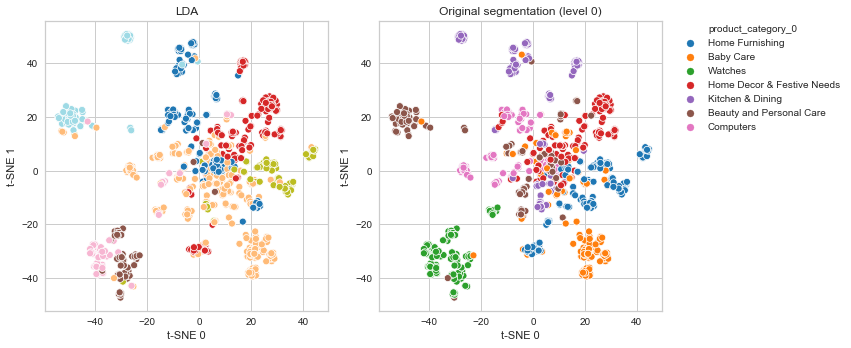

In [1016]:
svd = decomposition.TruncatedSVD(n_components=100)
normalizer = preprocessing.Normalizer(copy=False)
lsa = pipeline.make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(docterm)
tsne = manifold.TSNE(perplexity=30, n_iter=4000)
X_tsne = tsne.fit_transform(X_lsa)

visualize_tsne(data, X_tsne, "LDA_topic", title="LDA")

**5. Evaluations de la segmentation**
1. Evaluation relative aux "vraies" catégories

In [772]:
def eval_clustering(true_labels, cluster_labels, text="LDA"):
    # Encodage numérique des vraies catégories
    print("ARI entre les étiquettes obtenues par {} et les vraies étiquettes: {:.2f}"
          .format(text, metrics.adjusted_rand_score(true_labels, cluster_labels)))    

In [1020]:
eval_clustering(data.label_0, topics, text='LDA')

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.25


2. Evaluation "absolue" par la méthode du coude sur le score de distorsion

In [1005]:
def compute_distorsion(X, topics):
    
    distorsions = []
    
    for t in np.unique(topics):
        cluster_indices = np.where(topics==t)
        centroid = X[cluster_indices].sum(axis=0) / len(cluster_indices[0])
        distorsions.append((np.square(X[cluster_indices] - centroid)).sum(axis=1))
    distorsion = np.sum(list(itertools.chain.from_iterable(distorsions)))
    
    return distorsion

100%|██████████| 9/9 [03:07<00:00, 20.80s/it]


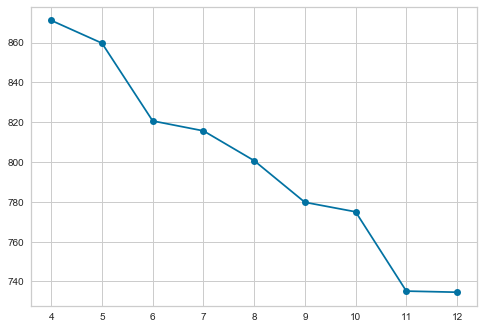

In [1006]:
distorsions = []
range_clust = (4, 13)

for ntopics in tqdm(range(*range_clust)):
    # Créer le modèle LDA
    lda = LatentDirichletAllocation(
    n_components=ntopics, 
    max_iter=100,
    evaluate_every=5,
    perp_tol=0.05,
    learning_method='batch', 
    learning_decay=0.7)

    # Fitter sur les données - on utilise la matrice "bag-of-words"
    lda.fit(docterm)
    
    # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
    X_topics = lda.transform(docterm)
    topics = np.argmax(X_topics, axis=1)
    
    # score de distorsion
    
    distorsions.append(compute_distorsion(docterm, topics))
    

plt.plot(np.arange(*range_clust), distorsions, 'o-')

**Score de Silhouette**

In [1018]:
metrics.silhouette_score(X_tsne, topics)

0.10150083

In [1019]:
metrics.silhouette_score(X_tsne, data["product_category_0"])

0.1861226

**Inspection de la matrice de confusion**

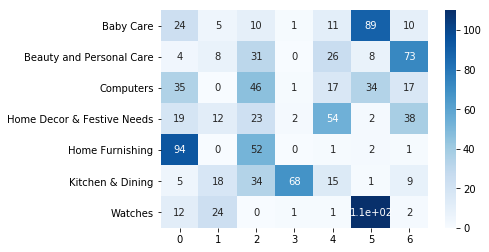

In [170]:
conf_mat = metrics.confusion_matrix(labels, topics)
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_classes],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Beaucoup de produits regroupés dans seulement 3 des 7 topics.

## K-Means pipeline

**1. Réduction dimensionnelle par SVD (Latent Semantic Analysis)**

In [819]:
# création de la matrice 'bag_of_words'
docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True)

svd = decomposition.TruncatedSVD(n_components=100)
normalizer = preprocessing.Normalizer(copy=False)
lsa = pipeline.make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(docterm)

**2. Segmentation avec K-Means**

In [820]:
km = cluster.KMeans(
        n_clusters=7,
        init="k-means++",
        max_iter=100,
        n_init=10,
    )

km.fit(X_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**3. Affichage des topics générés**

In [821]:
original_space_centroids = lsa.named_steps["truncatedsvd"].inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = docterm.columns
for i in range(7):
    print("Cluster {}: ".format(i))
    print(" ".join([terms[ind] for ind in order_centroids[i, :10]]))
    print()

Cluster 0: 
blanket single abstract quilt double comforte multicolor floral raymond rajasthan

Cluster 1: 
pack inch color box feature model material design price cushion

Cluster 2: 
showpiece best online price kadhai usb led handicraft sticker brass

Cluster 3: 
watch analog men discount india great woman online dial boy

Cluster 4: 
mug ceramic coffee prithish perfect rockmantra gift design loved safe

Cluster 5: 
set combo towel online laptop bath cotton cell skin battery

Cluster 6: 
baby girl detail fabric cotton dress boy sleeve neck pattern



**4. Visualisation avec t-SNE**

In [758]:
def visualize_tsne(data, X_tsne, label_col, title="K-Means clusterization"):
    
    X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])
    df = pd.concat([X_tsne, data[[label_col, "product_category_0"]]], axis=1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12, 5))

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue=label_col,palette='tab20', legend=False, ax=ax1)
    #ax1.legend(np.arange(len(np.unique(df.hdbs_label)))-1)
    ax1.set_title(title)

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10', ax=ax2)
    ax2.set_title("Original segmentation (level 0)")
    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

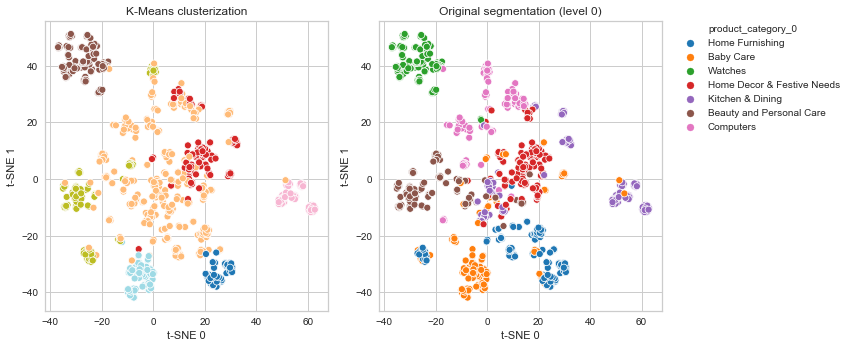

In [824]:
tsne = manifold.TSNE(perplexity=30, n_iter=4000)
X_tsne = tsne.fit_transform(X_lsa)
data["km_label"] = km.labels_
visualize_tsne(data, X_tsne, "km_label")

**5. Evaluation de la segmentation**

1. Relative aux "vraies" catégories

In [825]:
eval_clustering(data.label_0, km.labels_)

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.29


2. Evaluation absolue par la méthode du coude

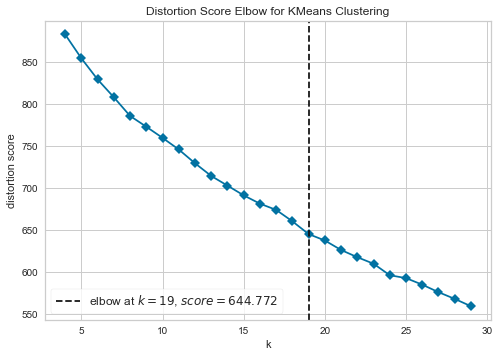

In [893]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,30), timings=False
)

visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

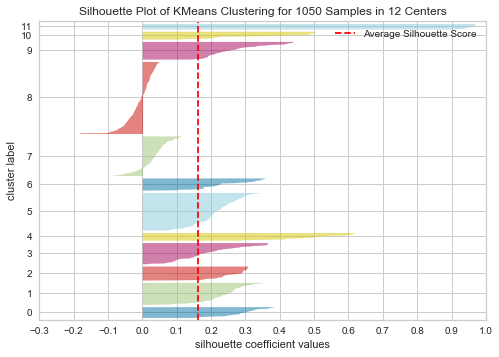

In [892]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [1023]:
km = cluster.KMeans(
        n_clusters=12,
        init="k-means++",
        max_iter=100,
        n_init=10,
    )

km.fit(X_lsa)

print("silhouette score pour nb optimal de clusters: {:.2f}".format(metrics.silhouette_score(X_tsne, km.labels_)))
print("silhouette score sur catégories originales: {:.2f}".format(metrics.silhouette_score(X_tsne, data.label_0)))

silhouette score pour nb optimal de clusters: 0.26
silhouette score sur catégories originales: 0.19


## HDBSCAN Pipeline

**0. LSA et réduction de dimension par t-SNE**

In [1031]:
# création de la matrice 'bag_of_words'
_, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True)
svd = decomposition.TruncatedSVD(n_components=100)
normalizer = preprocessing.Normalizer(copy=False)
lsa = pipeline.make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(docterm)


tsne = manifold.TSNE(perplexity=30, n_iter=4000)
X_tsne = tsne.fit_transform(X_lsa)

**1. Segmentation avec hdbscan**

In [857]:
def hdbs_clustering(X, data, model):

    model.fit(X)
    hdbs_labels = model.labels_
    print("Nombre de clusters trouvés (le bruit compte pour un cluster): {}"
          .format(len(np.unique(hdbs_labels))))
    data["hdbs_label"] = hdbs_labels
    data["hdbs_label"] = data["hdbs_label"].apply(lambda x: "cluster_{}".format(x))
    
    return data

In [879]:
clusterer = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=65)
df = hdbs_clustering(X_lsa, data, clusterer)

Nombre de clusters trouvés (le bruit compte pour un cluster): 8


**2. Visualisation avec t-SNE**

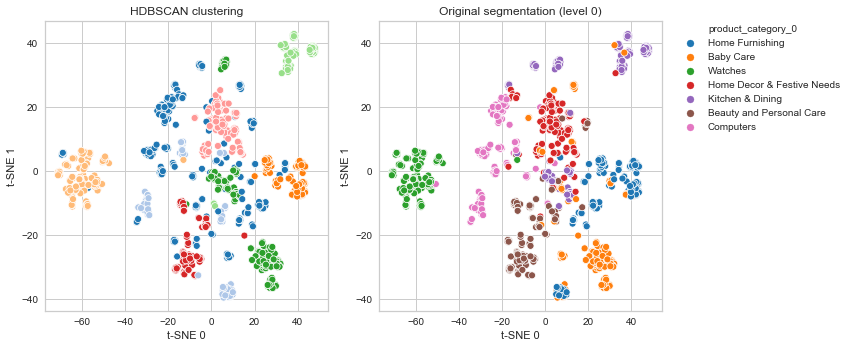

In [880]:
# Visualisation
visualize_tsne(df, X_tsne, "hdbs_label", title="HDBSCAN clustering")

**3. Evaluation de la segmentation** 

In [881]:
# Evaluation
eval_clustering(df.label_0, df.hdbs_label)

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.43


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


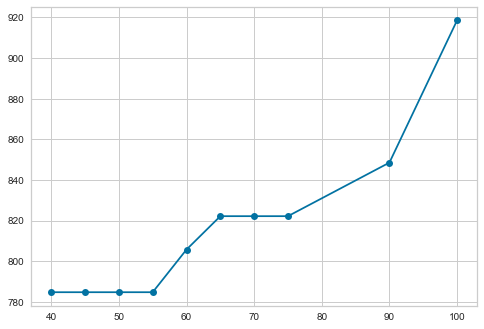

In [875]:
distorsions = []
minclustersize = [40, 45, 50, 55, 60, 65, 70, 75, 90, 100]

for mcs in tqdm(minclustersize):
    # Créer le modèle LDA
    hdbs = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=mcs)
    
    # Fitter sur les données - on utilise la matrice "bag-of-words"
    hdbs.fit(X_lsa)
    
    # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
    
    #X_topics = lda.transform(docterm)
    #topics = np.argmax(X_topics, axis=1)
    
    topics = hdbs.labels_
    
    # score de distorsion
    distorsions.append(compute_distorsion(X_lsa, topics))
    

plt.plot(minclustersize, distorsions, 'o-')

In [1032]:
# Créer le modèle LDA
hdbs = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=75)
    
# Fitter sur les données - on utilise la matrice "bag-of-words"
hdbs.fit(X_lsa)
    
# Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale

#X_topics = lda.transform(docterm)
#topics = np.argmax(X_topics, axis=1)
print("Nombre de clusters trouvés (le bruit compte pour un cluster): {}"
          .format(len(np.unique(hdbs.labels_))))
print("silhouette score pour les clusters: {:.2f}".format(metrics.silhouette_score(X_tsne, hdbs.labels_)))

Nombre de clusters trouvés (le bruit compte pour un cluster): 7
silhouette score pour les clusters: 0.16


In [1033]:
print("silhouette score pour les catégories originales: {:.2f}".format(metrics.silhouette_score(X_tsne, data.label_0)))

silhouette score pour les catégories originales: 0.30
